# IMPORTS

In [25]:
import pandas as pd

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline

In [27]:
from sklearn.preprocessing import RobustScaler

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [29]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))

# DATASET


#### Stock prices of Berkshair Hathway

In [30]:
df = pd.read_csv("C:\\Users\\sudha\\Dropbox\\PC\\Downloads\\BRK-B (2).csv")

In [31]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,36.500000,36.580002,34.820000,35.299999,35.299999,875000
1,2000-01-04,34.500000,34.660000,33.900002,34.080002,34.080002,1380000
2,2000-01-05,34.139999,35.459999,33.900002,34.639999,34.639999,995000
3,2000-01-06,34.900002,36.080002,34.540001,36.080002,36.080002,915000
4,2000-01-07,36.599998,36.959999,36.099998,36.400002,36.400002,1000000
...,...,...,...,...,...,...,...
4375,2017-05-24,165.899994,165.899994,164.550003,164.929993,164.929993,2597300
4376,2017-05-25,165.229996,165.500000,164.710007,165.300003,165.300003,2605300
4377,2017-05-26,165.250000,165.880005,165.020004,165.690002,165.690002,2156300
4378,2017-05-30,165.789993,165.869995,164.470001,165.110001,165.110001,3048300


In [32]:
df_cls=df.reset_index()['Close']

In [33]:
df_cls=scaler.fit_transform(np.array(df_cls).reshape(-1,1))

In [34]:
training_size=int(len(df_cls)*0.9)
test_size=len(df_cls)-training_size
train_data,test_data=df_cls[0:training_size,:],df_cls[training_size:len(df_cls),:1]

#### We consider 100 previous time-steps to predict the next Close price, hence we create a function to do the same

In [35]:
def create_dataset1(dataset, time_step=1):
    """
    Input: Dataset
    output: Dataset with 100 timesteps
    """
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [36]:
time_step = 100 #####HYPERPARAMETER
X_train, y_train = create_dataset1(train_data, time_step)
X_test, ytest = create_dataset1(test_data, time_step)

In [37]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

# OPTIMIZERS

In [38]:
opt = keras.optimizers.Adam(learning_rate=0.0001)

In [39]:
opt2 = tf.keras.optimizers.SGD(
    learning_rate=0.01, momentum=0.0, nesterov=False, name="SGD"
)

# HYPERPARAMETER TUNING

In [40]:
import keras_tuner
from tensorflow import keras

In [41]:
"""
Implementing Early stopping
"""
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [1]:
"""
LSTM Model
"""
def model1(hp):
    model=Sequential()
    model.add(LSTM( hp.Choice('units',[32,64,128,256]),return_sequences=True,input_shape=(100,1)))
    model.add(LSTM( hp.Choice('units',[8,16,32,64,128]),return_sequences=True))
    model.add(LSTM( hp.Choice('units',[4,8,16])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',optimizer= opt)
    return model

In [49]:
tuner = keras_tuner.RandomSearch(
    model1,
    objective='val_loss',
    max_trials=20,
    executions_per_trial = 2,
    directory = r"C:\Users\sudha\yashu",
    project_name = "bestmodel")

In [50]:
tuner.search(X_train, y_train, epochs=40, validation_data=(X_test, ytest),batch_size=64,verbose=1, callbacks= [es])
best_model = tuner.get_best_models()[0]

Trial 4 Complete [00h 01m 32s]
val_loss: 0.0005330942221917212

Best val_loss So Far: 0.0002980876015499234
Total elapsed time: 00h 09m 21s
INFO:tensorflow:Oracle triggered exit


In [46]:
p=tf.config.list_physical_devices('GPU')
print(p)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [51]:
"""
Best Model built using Gridsearch (HyperOpt)
"""
best_model.build(input_shape = (100,1))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 256)          264192    
                                                                 
 lstm_1 (LSTM)               (None, 100, 256)          525312    
                                                                 
 lstm_2 (LSTM)               (None, 256)               525312    
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 1,315,073
Trainable params: 1,315,073
Non-trainable params: 0
_________________________________________________________________


In [52]:
"""
Training...
"""
best_hps = tuner.get_best_hyperparameters(5)
model_best = model1(best_hps[0])
model_best.fit(X_train,y_train,validation_data = (X_test, ytest), epochs=50, batch_size=64, verbose=1, callbacks=[es])

Epoch 1/50
61/61 [==============================] - 6s 54ms/step - loss: 0.0092 - val_loss: 8.7690e-04
Epoch 2/50
61/61 [==============================] - 2s 39ms/step - loss: 2.3734e-04 - val_loss: 9.6096e-04
Epoch 3/50
61/61 [==============================] - 2s 39ms/step - loss: 2.2807e-04 - val_loss: 6.6765e-04
Epoch 4/50
61/61 [==============================] - 2s 39ms/step - loss: 2.2649e-04 - val_loss: 5.0621e-04
Epoch 5/50
61/61 [==============================] - 2s 39ms/step - loss: 2.2352e-04 - val_loss: 4.8337e-04
Epoch 6/50
61/61 [==============================] - 2s 40ms/step - loss: 2.2087e-04 - val_loss: 4.9533e-04
Epoch 7/50
61/61 [==============================] - 3s 43ms/step - loss: 2.1632e-04 - val_loss: 4.6144e-04
Epoch 8/50
61/61 [==============================] - 3s 45ms/step - loss: 2.1749e-04 - val_loss: 4.5506e-04
Epoch 9/50
61/61 [==============================] - 2s 41ms/step - loss: 2.1255e-04 - val_loss: 4.7728e-04
Epoch 10/50
61/61 [======================

In [54]:
train_predict=model_best.predict(X_train)
test_predict=model_best.predict(X_test)

11/11 [==============================] - 0s 17ms/step


In [55]:
"""
Inverse_transform to bring it back to the original domain.
"""
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [56]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

80.26388302299229

In [57]:
math.sqrt(mean_squared_error(ytest,test_predict))

152.2205796650225

# Predictions

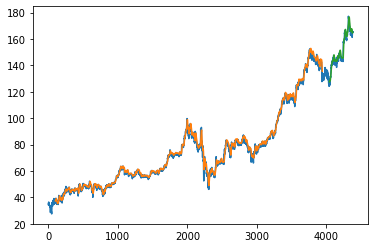

In [58]:
"""
Blue Line: Orignal Stock Price Behaviour
Yellow Line: Model Predictions during Training
Green Line: Model Predictions during Testing (1 Day ahead)
"""
look_back=100
trainPredictPlot = np.empty_like(df_cls)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df_cls)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df_cls)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df_cls))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Preparing Data For Future Predictions

In [59]:
len(test_data)

438

In [60]:
x_input=test_data[338:].reshape(1,-1)
x_input.shape

(1, 100)

In [61]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [63]:
temp_input

[0.9074593335165421,
 0.8981852475192503,
 0.8945156251302083,
 0.8995863150492814,
 0.8941153248873451,
 0.8973845402814554,
 0.8823058438904846,
 0.8879770875899192,
 0.8807713162581484,
 0.8861089397258403,
 0.8767680736373636,
 0.8895116218942595,
 0.9130637904527875,
 0.9175340199995597,
 0.9140645510679514,
 0.9167334128418295,
 0.9123298633061773,
 0.9087937143634489,
 0.9047237850595394,
 0.9109954824592706,
 0.907526013527662,
 0.9042566980534873,
 0.90385639113862,
 0.9116626228426917,
 0.9114624760572624,
 0.9237390373881708,
 0.9310781820861901,
 0.9332799568540163,
 0.9363491188707572,
 0.9418868957958827,
 0.9442220372579532,
 0.948825740251039,
 0.9524285758768919,
 0.952895662882944,
 0.9556312113399467,
 0.9609020480444491,
 0.9999999999999999,
 0.9907259140027082,
 0.9893247530646166,
 0.9874565985285334,
 0.9867894581451125,
 0.9845876833772863,
 0.9872564450710998,
 0.9846543700604108,
 0.9873899118454089,
 0.9829863689817612,
 0.9825860620668939,
 0.978649606209298

In [64]:
from numpy import array



# Adj Close Price Predictions for the next 10 Days

In [66]:
"""
lst output is the list which will contain the future price prediction
"""
lst_output=[]
n_steps=100
i=0
while(i<10):
    
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model_best.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]

        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model_best.predict(x_input, verbose=0)
        print(yhat[0])
        
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.92535895]
101
1 day input [0.89818525 0.89451563 0.89958632 0.89411532 0.89738454 0.88230584
 0.88797709 0.88077132 0.88610894 0.87676807 0.88951162 0.91306379
 0.91753402 0.91406455 0.91673341 0.91232986 0.90879371 0.90472379
 0.91099548 0.90752601 0.9042567  0.90385639 0.91166262 0.91146248
 0.92373904 0.93107818 0.93327996 0.93634912 0.9418869  0.94422204
 0.94882574 0.95242858 0.95289566 0.95563121 0.96090205 1.
 0.99072591 0.98932475 0.9874566  0.98678946 0.98458768 0.98725645
 0.98465437 0.98738991 0.98298637 0.98258606 0.97864961 0.97024291
 0.96523891 0.94789166 0.94675743 0.95069389 0.94248736 0.9343475
 0.94015211 0.92867625 0.93381373 0.92927671 0.93054441 0.93047773
 0.92360557 0.92787565 0.92587403 0.92707504 0.92273818 0.91880172
 0.90405654 0.91373103 0.90932748 0.90312247 0.91793433 0.90745933
 0.92327195 0.93494796 0.9356152  0.92840942 0.91946896 0.92100349
 0.92507342 0.92961033 0.92700825 0.92840942 0.91820126 0.90779295
 0.90952763 0.90652525 0.90685887 0.910061

In [67]:
day_new=np.arange(1,101)
day_pred=np.arange(101,111)

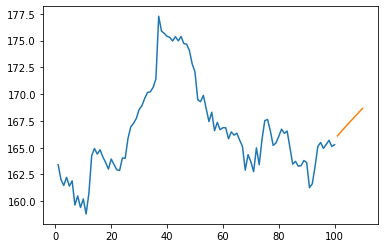

In [70]:
"""
Graph Showing Future Price Predictions for Berkshire Hathway stock for 10 Days
From 31th May 2017- 10th June 2017

Actual Closing Price at June 12th was 170.48 Dollars, nearly in line with my prediction that stock was going to go up to 170 Dollars
"""
plt.plot(day_new,scaler.inverse_transform(df_cls[4280:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

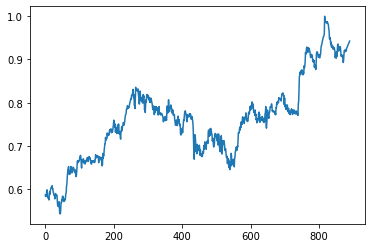

In [72]:
df3=df_cls.tolist()
df3.extend(lst_output)
plt.plot(df3[3500:])

In [73]:
df3=scaler.inverse_transform(df3).tolist()

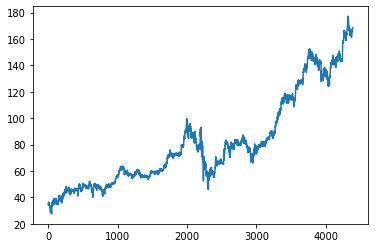

In [74]:

plt.plot(df3)

In [75]:
lst_output

[[0.9253589510917664],
 [0.9273728132247925],
 [0.9293588399887085],
 [0.9313104152679443],
 [0.9331871271133423],
 [0.9350696802139282],
 [0.936933696269989],
 [0.9388120174407959],
 [0.9406788945198059],
 [0.9425441026687622]]